<a href="https://colab.research.google.com/github/peterkahumu/deep-learning/blob/main/Image_classification_cats_and_dogs_overfitting_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook aims to provide a solution to _overfitting_ as experienced in [this](https://colab.research.google.com/drive/1OGbIVyYRBVL2wGbFnY4n-90YuLKWtS2G#scrollTo=7oIyMd_B-rao) exercise. The  model overfitted, performing very well in the process of training but poorly in validation.
<hr>
 In this notebook, I will apply the following techniques to the dataset:

1. Image Augmentation
2. Dropouts

<hr>
The following is the general machine learning workflow that I used in this exercise:

1. Examine and understand the data
2. Build aninput pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model / Repeat the process.

## Importing the packages



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt


# Load the data

The dataset is a filtered version of [Dogs and Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset from Kaggle.

I shall make use of the class `tf.keras.preprocessing.image.ImageDataGenerator` to load the data from the disk.

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin = _URL, extract = True )

68606236/68606236 [==============================] - 1s 0us/step


In [ ]:
# assign variables with proper file paths to the training and test sets.
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats') # directory with the training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # directory with the training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Understanding the data


In [ ]:
# check the number of training and validation entries present dataset
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images: ', num_cats_tr)
print('total training dog images: ', num_dogs_tr)

print('total validation cat images: ', num_cats_val)
print('total validation dog images: ', num_dogs_val)
print("--")
print("Total training images: ", total_train)
print("Total validation images: ", total_val)

total training cat images:  1000
total training dog images:  1000
total validation cat images:  500
total validation dog images:  500
--
Total training images:  2000
Total validation images:  1000


# Setting Parameters for the Model


In [ ]:
batch_size = 100
img_size = 150 # in pixels

# Data Augmentation

_Overfitting_ occurs when there's a small training dataset.

_Data Augmentation_ takes the approach of generating more training data from existing training samples, by applying different transformations to the existing images to generate new ones. This exposes the model to more aspects of data.

In [ ]:
# define a function to plot the images
def plotImages(image_arr):
  fig, axes = plt.subplots(1, 5, figsize = (20, 20))
  axes = axes.flatten()

  for img, ax in zip(image_arr, axes):
    ax.imshow(img)

  plt.tight_layout()
  plt.show()

## Flip the image horizontally


In [ ]:
image_gen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

train_data_gen = image_gen.flow_from_directory(batch_size = batch_size,
                                               directory = train_dir,
                                               shuffle = True,
                                               target_size = (img_size, img_size))

Found 2000 images belonging to 2 classes.


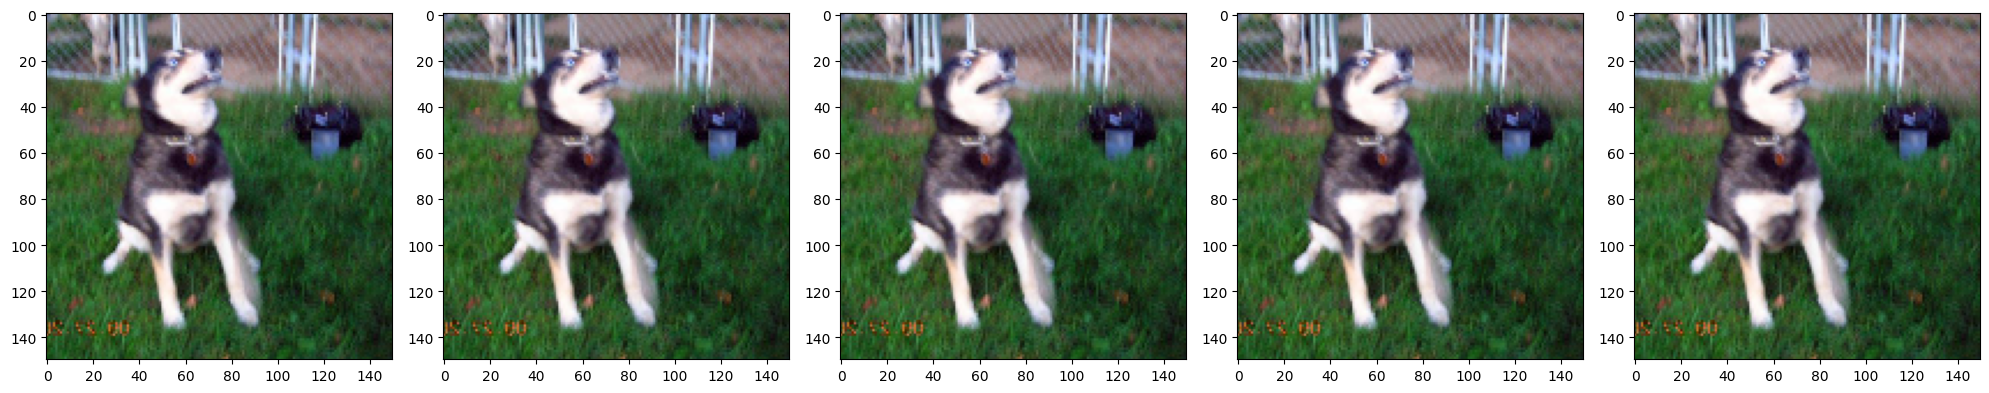

In [ ]:
# plot one sample image and its' transformation. Repeats the transformation 5 times.
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Rotating the image

In [ ]:
# rotate the image at an angle of 45 degrees
image_gen = ImageDataGenerator(rescale = 1./255, rotation_range = 45)

train_data_gen = image_gen.flow_from_directory(batch_size = batch_size,
                                               directory = train_dir,
                                               shuffle = True,
                                               target_size = (img_size, img_size))

Found 2000 images belonging to 2 classes.


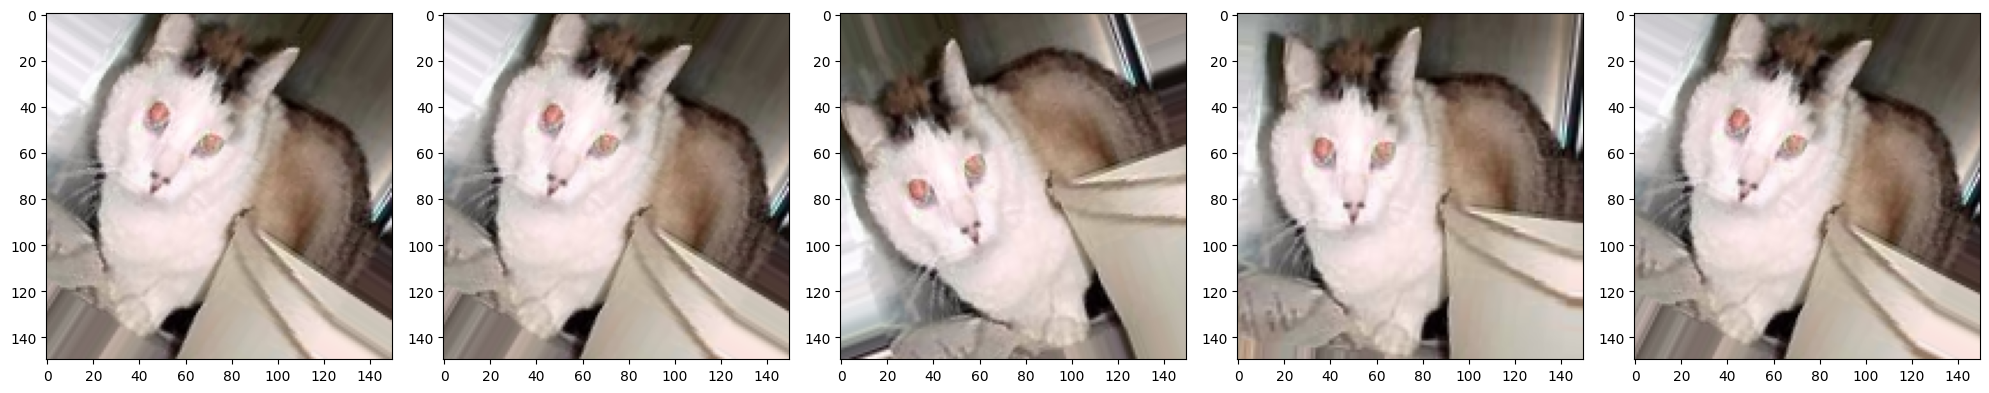

In [ ]:
# plot the images
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## Applying zoom to the images



In [ ]:
# combinining the different methods of augmentation.
image_gen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.5)

train_data_gen = image_gen.flow_from_directory(batch_size = batch_size,
                                               directory = train_dir,
                                               shuffle = True,
                                               target_size = (img_size, img_size))


Found 2000 images belonging to 2 classes.


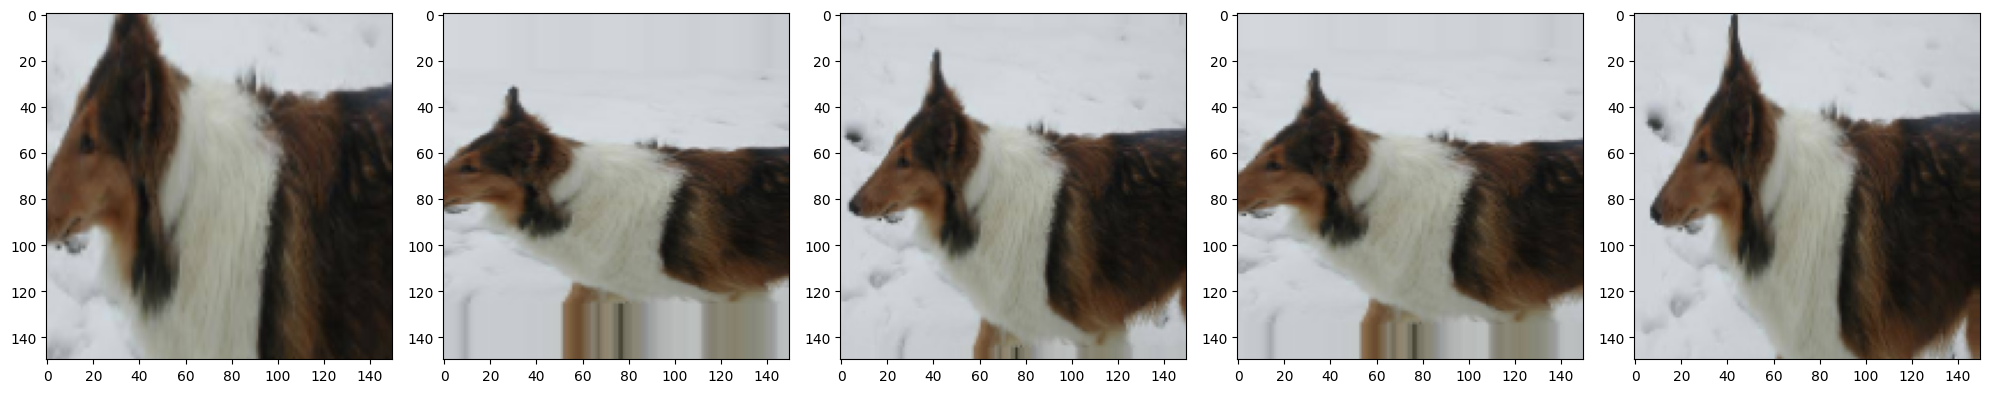

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## Applying all the Augmentation methods together

In [ ]:
image_gen_train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_data_gen = image_gen.flow_from_directory(batch_size = batch_size,
                                               directory = train_dir,
                                               shuffle = True,
                                               target_size = (img_size, img_size),
                                               class_mode = 'binary')

Found 2000 images belonging to 2 classes.


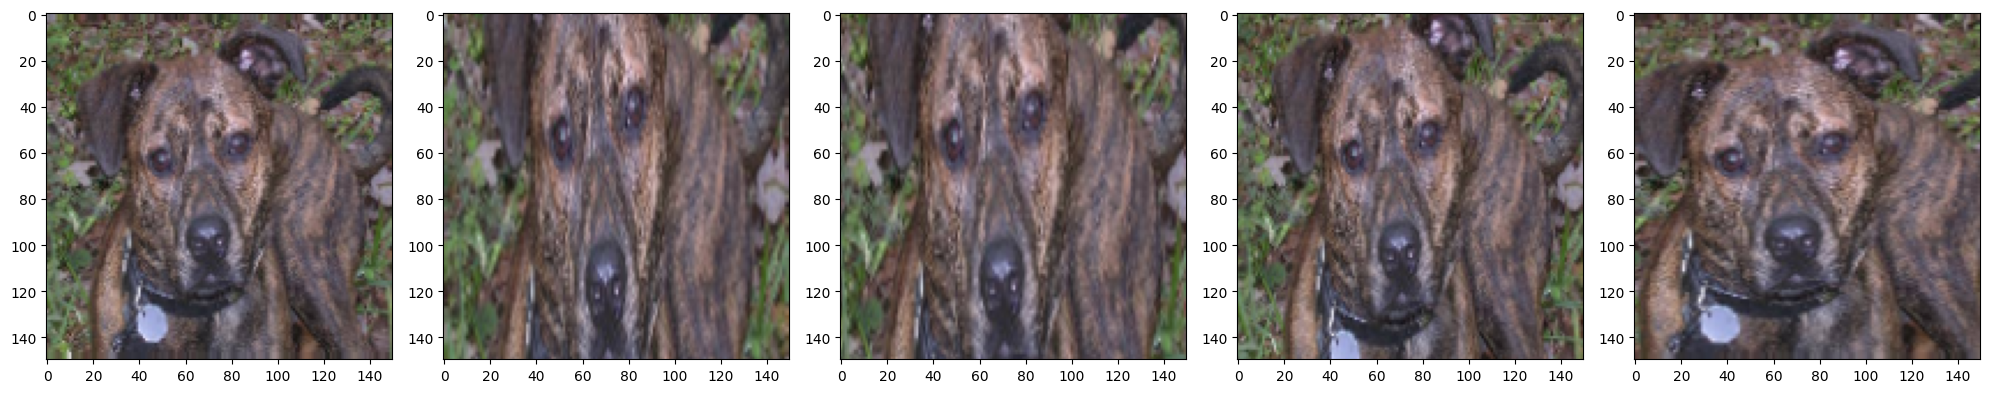

In [ ]:
# visualizing how a single image will appear different times.
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
# cross validation data. Augmentation is not applied to the validation dataset
# only rescalling is applied.
image_gen_val = ImageDataGenerator(rescale = 1./255)
val_data_gen = image_gen.flow_from_directory(batch_size = batch_size,
                                             directory = validation_dir,
                                             target_size = (img_size, img_size),
                                             class_mode = 'binary')

Found 1000 images belonging to 2 classes.


# Model Creation

## Model Definition.

The models contains:

1. four convolutio blocks with a max pool layer each.
2. A dropout layer witha probability of 0.5
3. Fully connected layer with 512 units.
4. A relu activation function.
5. Output layer for two classes, dogs and cats using softmax.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(2)
])


# compile the model using adam optimizer

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [ ]:
# model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

# Train the model.

In [ ]:
epochs = 100
history = model.fit(train_data_gen,
                    steps_per_epoch = int(np.ceil(total_train / float(batch_size))),
                    epochs = epochs,
                    validation_data = val_data_gen,
                    validation_steps = int(np.ceil(total_val / float(batch_size))))

Epoch 1/100
20/20 [==============================] - 30s 1s/step - loss: 0.7052 - accuracy: 0.5175 - val_loss: 0.7011 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 20s 1s/step - loss: 0.6922 - accuracy: 0.5090 - val_loss: 0.6910 - val_accuracy: 0.5540
Epoch 3/100
20/20 [==============================] - 23s 1s/step - loss: 0.6893 - accuracy: 0.5415 - val_loss: 0.6807 - val_accuracy: 0.6260
Epoch 4/100
20/20 [==============================] - 19s 941ms/step - loss: 0.6770 - accuracy: 0.5930 - val_loss: 0.6678 - val_accuracy: 0.5970
Epoch 5/100
20/20 [==============================] - 19s 976ms/step - loss: 0.6772 - accuracy: 0.5925 - val_loss: 0.6975 - val_accuracy: 0.5180
Epoch 6/100
20/20 [==============================] - 18s 921ms/step - loss: 0.6500 - accuracy: 0.6120 - val_loss: 0.6367 - val_accuracy: 0.6180
Epoch 7/100
20/20 [==============================] - 27s 1s/step - loss: 0.6262 - accuracy: 0.6460 - val_loss: 0.6094 - val_accuracy: 0.6550
Epoc

# Visualize the results.

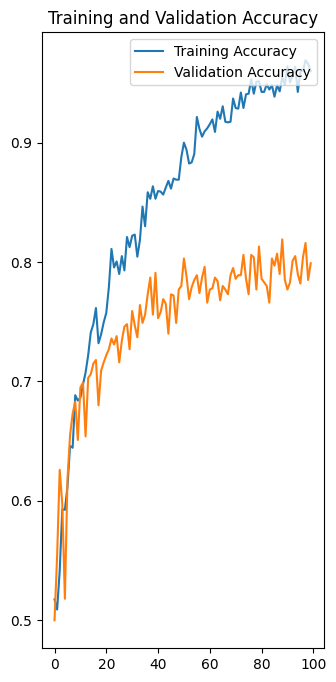

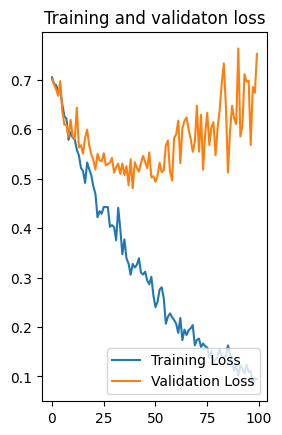

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = "Validation Loss")
plt.legend(loc = 'lower right')
plt.title('Training and validaton loss')
plt.show()